# Basic Decision Trees
## The Problem
Let's start with a concrete example of the type of problem we are going to discuss.  Supposed that you are a bird watcher and you have been tracking if your favorite Barn Swallow shows up during lunch time.  You have been keeping track of a number of different variables (in machine learning we call these "features") every morning along with whether or not your friend shows up during lunch.  The features you record are:

| Feature Name | Possible Values      |
|--------------|----------------------|
| Outlook      |Sunny, Overcast, Rain |
| Temperature  |Cool, Mild, Hot       |
| Humidity     |High, Normal          |
| Windy        |True, False           |

This is called "categorical data" because each feature takes on a single value from a finite set of possible values.  Categorical data is often created by grouping data that is otherwise continuous (e.g. Temperature gets grouped into Cool, Mild or Hot based on some criterion).

The goal of this type of machine learning problem is to determine, based on a particular measurement or "instance" of the features values (i.e. Outlook, Temperature, Humidity, Windy), whether our bird friend will show up.  This is called a binary classification problem because we are classifying instances (e.g. Outlook=Overcast, Temperature=Hot, Humidity=High, Windy=True) as either thumbs up (the bird shows up) or thumbs down (the bird does not show up).

## A Solution
The mathematical view of the above problem is that we are looking for a function.  Functions map each input to one and only one output.  The function in this case maps (Outlook, Temperature, Humidity, Windy) to thumbs up or thumbs down.  How many different possible functions are there to choose from?

There are $3 \cdot 3 \cdot 2 \cdot 2 = 36$ possible inputs (Outlook has 3 possibilities, Temperature has 3, Humidity has 2 and Windy has 2 possibilities).  For each input the function can evaluate to one of two values (thumbs up or thumbs down).  Thus there are $2^{36}=68,719,476,736$ possible functions associated with this simple problem.

### A Little Theory
Does it surprise you that a problem this simple has so many different possible solutions?  This is just a fact of life for machine learning practitioners.  Consider the case of a problem with $N$ features each of which can take on 2 values in a binary classification problem.  In this case, the number of possible solutions/functions is

$$2^{2^{N}}$$

(each of the $2^{N}$ possible inputs has 2 possible outputs).  Note that the size of the solution space grows like a double exponential with the number of features involved.  Clearly a brute force search of the solution space is not viable.

It is useful to note that even just to explicitly represent the single "correct" function that we are after requires exponential memory - we need to remember the output for each of the $2^{N}$ possible inputs.  Of course if we know the correct output for every input we don't have a learning problem.  We have (in practice at least) a compression problem.  If we choose to use lossy compression then we are effectively approximating a known function.  Neither of these is learning.

### What is Learning?
There are a number of different types of learning problems.  For the most part they all involve trying to approximate a function based on instance data (sets of features) which may (supervised learning) or may not (unsupervised learning) have "correct" outputs associated with them.

Typically the amount of data available to learn from is a tiny fraction of the set of all possible inputs (i.e. all possible combinations of feature values).  Given this, it is reasonable ask if "learning" is even possible.  How can we possibly know what value a function will take on without observing what it actually evaluates to?  The answer is that it is not possible to learn "pathological" functions but it is possible to approximate functions that exhibit "large scale" patterns in their output which can be detected from sparse sampling.  We won't attempt here to rigorously defined the conditions under which "generalization" is possible.  We will simply state that if a data set of interest contains patterns that generalize to the full domain it is possible (at least in theory) to learn and exploit them.

### A Function?  Really?
It is quite reasonable to question whether a function is really what we are after here.  Surely whether or not our friendly Barn Swallow shows up depends on more than just some crude measures of the weather!  This is most likely true and is often true in real world cases as well.  There may be "unobserved" features such as the proximity of cats at lunch time or numerous other factors related to Barn Swallow psychology.  The best we can really hope for is to approximate the "real" underlying function using just the data that is available.  There will be "modeling" error that can't be avoided.  This is not quite as bad as it sounds since approximation is probably the best we can hope for any way given the sparseness of the data typically available.  We will come back to this point later when we discuss bias and variance.

### A Function Then - So How Do We Approximate It?
Before we tackle the question of how to approximate the function we are after it is useful to consider if it possible to always represent the function exactly if we have a complete set of inputs and outputs.  In machine learning choosing the manner in which the function will be represented is called choosing the "hypothesis space."  The specific function that is chosen based on the data is called the "hypothesis."   The hypothesis is restricted to be a member (in a set theoretic sense) of the hypothesis space.  In general the choice of hypothesis space can dramaticaly impact the quality of the resulting hypothesis (i.e. how well we are able to approximate the real function we are after) and the amount of work necessary to pick the best hypothesis.  For the case at hand - supervised learning of binary classification over categorical data - we are in luck since a simple hypothesis space is both fairly obvious and capable of exactly representing the functions we seek.

A simple way to represent a function that captures the observed instances is simply a series of if-then statements:

```python
if   Outlook=='Sunny' and Temperature=='Hot' and Humidity=='High' and Windy==False:
    return 'thumbs down'
elif Outlook=='Sunny' and Temperature=='Hot' and Humidity=='High' and Windy==True:
    return 'thumbs down'
#...
```

It should be fairly obvious that this hypothesis space (a series of if-then statements over all combinations of feature values) is capable of representing the function we are after exactly **if** we have the complete set of inputs and outputs.  The problem, as we mentioned before, however is that this is not learning.  If we already have all the inputs and outputs there is nothing to learn!  If we just use this "series of rules" approach on sparse input we are left with no ability to generalize to inputs that have not been observed (note - the rules based approach can be rescued but we won't consider it further here).  The if-then approach is promising however.  Consider the following instance data from which we wish to learn an approximate classifier function:

In [1]:
import pandas as pd
import itable
from IPython.display import display
values = zip(['Outlook', 'Temperature', 'Humidity', 'Windy', 'Barn Swallow?'],
    ['Sunny', 'Hot', 'High', False, 'thumbs down'], 
    ['Sunny', 'Hot', 'High', True, 'thumbs down'], 
    ['Overcast', 'Hot', 'High', False, 'thumbs up'],
    ['Rain', 'Mild', 'High', False, 'thumbs up'],
    ['Rain', 'Cool', 'Normal', False, 'thumbs up'],
    ['Rain', 'Cool', 'Normal', True, 'thumbs down'],
    ['Overcast', 'Cool', 'Normal', True, 'thumbs up'],
    ['Sunny', 'Mild', 'High', False, 'thumbs down'], 
    ['Sunny', 'Cool', 'Normal', False, 'thumbs up'],
    ['Rain', 'Mild', 'Normal', False, 'thumbs up'],
    ['Sunny', 'Mild', 'Normal', True, 'thumbs up'],
    ['Overcast', 'Mild', 'High', True, 'thumbs up'],
    ['Overcast', 'Hot', 'Normal', False, 'thumbs up'],
    ['Rain', 'Mild', 'High', True, 'thumbs down'])
df = pd.DataFrame({row[0]: row[1:] for row in values})
df = df.ix[:,['Outlook', 'Temperature', 'Humidity', 'Windy', 'Barn Swallow?']]
pt = itable.PrettyTable(df, tstyle=itable.TableStyle(theme="theme1"), center=True)
display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Sunny,Hot,High,False,thumbs down
Sunny,Hot,High,True,thumbs down
Overcast,Hot,High,False,thumbs up
Rain,Mild,High,False,thumbs up
Rain,Cool,Normal,False,thumbs up
Rain,Cool,Normal,True,thumbs down
Overcast,Cool,Normal,True,thumbs up
Sunny,Mild,High,False,thumbs down
Sunny,Cool,Normal,False,thumbs up
Rain,Mild,Normal,False,thumbs up


Examining this data carefully we see that there are patterns we can exploit. For example, when the Outlook is Overcast our friend always shows up (the tomato colored rows):

In [2]:
def df_rows(df, fname, fvalue):
    return df[df[fname] == fvalue].index.tolist()

def df_color(df, fname, fvalue_colors):
    pt = itable.PrettyTable(df, tstyle=itable.TableStyle(theme="theme1"), center=True)
    for fvalue, color in fvalue_colors.items():
        cs = itable.CellStyle()
        cs.set("background-color", color)
        pt.set_cell_style(style=cs, rows=df_rows(df, fname, fvalue))
    return pt

def df_gray_col(pt, cname):
    cs = itable.CellStyle()
    cs.set("background-color", "grey")
    pt.set_cell_style(style=cs, cols=[df.columns.get_loc(cname)])

OUTLOOK_COLORS = {'Overcast': 'tomato', 'Sunny': 'yellow', 'Rain': 'skyblue'}

pt = df_color(df, 'Outlook', OUTLOOK_COLORS)

display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Sunny,Hot,High,False,thumbs down
Sunny,Hot,High,True,thumbs down
Overcast,Hot,High,False,thumbs up
Rain,Mild,High,False,thumbs up
Rain,Cool,Normal,False,thumbs up
Rain,Cool,Normal,True,thumbs down
Overcast,Cool,Normal,True,thumbs up
Sunny,Mild,High,False,thumbs down
Sunny,Cool,Normal,False,thumbs up
Rain,Mild,Normal,False,thumbs up


This suggests a recursive approach of choosing one feature to group the data by and then examining the resulting groups as new instances of the same learning problem with one less feature.  Consider grouping the above on the Outlook feature:

In [3]:
df_sorted = df.sort_values('Outlook')
df_sorted.index = range(len(df_sorted))

pt = df_color(df_sorted, 'Outlook', OUTLOOK_COLORS)

display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Overcast,Hot,High,False,thumbs up
Overcast,Cool,Normal,True,thumbs up
Overcast,Mild,High,True,thumbs up
Overcast,Hot,Normal,False,thumbs up
Rain,Mild,High,False,thumbs up
Rain,Cool,Normal,False,thumbs up
Rain,Cool,Normal,True,thumbs down
Rain,Mild,Normal,False,thumbs up
Rain,Mild,High,True,thumbs down
Sunny,Hot,High,False,thumbs down


Conceptually we now have 3 data sets that we can work on independently.  Remember the end goal is to approximate the function that classifies instances (i.e. values of Outlook, Temperature, Humidity and Windy) in a way that is consistent with the learning examples we have to work with (i.e. the examples above).  The function that we have built so far looks like this if we express it as code:

```python
if Outlook == 'Overcast':
    # all Overcast instances have same classification
    return 'thumbs up'
elif Outlook == 'Rain':
    # split Rain instances on next feature (TBD)
elif Outlook == 'Sunny':
    # split Sunny instances on next feature (TBD)
```

It is important to note, however, that the functions we learn are not typically represented as code.  They are instead represented as a tree (hence the name "decision tree").  For this example, however, we will continue on by hand.

The first group of instances have Outlook equal to Overcast.  These all have the same classification so there is nothing to do - we have a rule that we can generalize to all instances (at least based on the data we have):

In [4]:
df_g1 = df_sorted.loc[df_sorted['Outlook'] == 'Overcast']
df_g1.index = range(len(df_g1))

pt = df_color(df_g1, 'Outlook', OUTLOOK_COLORS)
df_gray_col(pt, 'Outlook')
display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Overcast,Hot,High,False,thumbs up
Overcast,Cool,Normal,True,thumbs up
Overcast,Mild,High,True,thumbs up
Overcast,Hot,Normal,False,thumbs up


The second group of instances have Outlook equal to Rain.  These instances have mixed classification so we still have some work to do:

In [5]:
df_g2 = df_sorted.loc[df_sorted['Outlook'] == 'Rain']
df_g2.index = range(len(df_g2))

pt = df_color(df_g2, 'Outlook', OUTLOOK_COLORS)
df_gray_col(pt, 'Outlook')
display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Rain,Mild,High,False,thumbs up
Rain,Cool,Normal,False,thumbs up
Rain,Cool,Normal,True,thumbs down
Rain,Mild,Normal,False,thumbs up
Rain,Mild,High,True,thumbs down


We now need to choose the next feature to group the instances by.  In general, the best choice will be the feature that produce groups that are as close to "pure" (i.e. all share a single classification) as possible.  Based on this criterion, it looks like Windy is best feature to split on:

In [6]:
df_g2 = df_g2.sort_values('Windy')
df_g2.index = range(len(df_g2))

WINDY_COLORS = {True: 'lightpink', False:'wheat'}

pt = df_color(df_g2, 'Windy', WINDY_COLORS)
df_gray_col(pt, 'Outlook')
display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Rain,Mild,High,False,thumbs up
Rain,Cool,Normal,False,thumbs up
Rain,Mild,Normal,False,thumbs up
Rain,Cool,Normal,True,thumbs down
Rain,Mild,High,True,thumbs down


We are now left with two pure groups and we can update our classification function to be:

```python
if Outlook == 'Overcast':
    # all Overcast instances have same classification
    return 'thumbs up'
elif Outlook == 'Rain':
    if Windy == True:
        # all Rain and Windy instances have same classification
        return 'thumbs up'
    elif Windy == False:
        # all Rain and not Windy instances have same classification
        return 'thumbs down'
elif Outlook == 'Sunny':
    # split Sunny instances on next feature (TBD)
```

Finally, we need to repeat this proceed again with the Sunny Outlook Group:

In [7]:
df_g3 = df_sorted.loc[df_sorted['Outlook'] == 'Sunny']
df_g3.index = range(len(df_g3))

pt = df_color(df_g3, 'Outlook', OUTLOOK_COLORS)
df_gray_col(pt, 'Outlook')
display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Sunny,Hot,High,False,thumbs down
Sunny,Hot,High,True,thumbs down
Sunny,Mild,High,False,thumbs down
Sunny,Cool,Normal,False,thumbs up
Sunny,Mild,Normal,True,thumbs up


Here we see that the Humidity feature splits the instances into pure groups:

In [8]:
df_g3 = df_g3.sort_values('Humidity')
df_g3.index = range(len(df_g3))

HUMIDITY_COLORS = {'High': 'wheat', 'Normal':'lightpink'}

pt = df_color(df_g3, 'Humidity', HUMIDITY_COLORS)
df_gray_col(pt, 'Outlook')
display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Sunny,Hot,High,False,thumbs down
Sunny,Hot,High,True,thumbs down
Sunny,Mild,High,False,thumbs down
Sunny,Cool,Normal,False,thumbs up
Sunny,Mild,Normal,True,thumbs up


This exhausts all of the instance data we have to learn from.  The classification function that we have learned is:

```python
if Outlook == 'Overcast':
    # all Overcast instances have same classification
    return 'thumbs up'
elif Outlook == 'Rain':
    if Windy == True:
        # all Rain and Windy instances have same classification
        return 'thumbs up'
    elif Windy == False:
        # all Rain and not Windy instances have same classification
        return 'thumbs down'
elif Outlook == 'Sunny':
    if Humidity == 'High':
        # all Sunny and High Humidity instance have same classification
        return 'thumbs down'
    elif Humidity == 'Normal':
        # all Sunny and High Humidity instance have same classification
        return 'thumbs up'    
```

This function is consistent with all of the instance data that we have available and will assign a classification to any legal instance (i.e. it is a complete function to classifies all inputs in the Outlook, Temperature, Humidity, Windy domain).  It is important to note, however, that this function is not in any way unique.

If we had chosen to begin splitting on the Temperature feature instead of the Outlook feature we would have arrived at a very different function.  Grouping on Temperature, our instance data looks like this:

In [9]:
TEMPERATURE_COLORS = {'Mild': 'chartreuse', 'Cool': 'cyan', 'Hot': 'orange'}

df_sorted2 = df.sort_values('Temperature')
df_sorted2.index = range(len(df_sorted2))

pt = df_color(df_sorted2, 'Temperature', TEMPERATURE_COLORS)

display(pt)

Outlook,Temperature,Humidity,Windy,Barn Swallow?
Rain,Cool,Normal,False,thumbs up
Rain,Cool,Normal,True,thumbs down
Overcast,Cool,Normal,True,thumbs up
Sunny,Cool,Normal,False,thumbs up
Sunny,Hot,High,False,thumbs down
Sunny,Hot,High,True,thumbs down
Overcast,Hot,High,False,thumbs up
Overcast,Hot,Normal,False,thumbs up
Rain,Mild,High,False,thumbs up
Sunny,Mild,High,False,thumbs down


An example (not unique) of a classification function that we could generate starting with grouping on Temperature is the following:

```python
# alternative more complicated classification function
if Temperature == 'Cool':
    if Outlook == 'Sunny':
        return 'thumbs up'
    elif Outlook == 'Overcast':
        return 'thumbs up'
    elif Outlook == 'Rain':
        # instances not pure - split on Windy
        if Windy == True:
            return 'thumbs down'
        elif Windy == 'False':
            return 'thumbs up'
elif Temperature == 'Mild':
    if Outlook == 'Sunny':
        # instances not pure - split on Windy
        if Windy == True:
            return 'thumbs up'
        elif Windy == 'False':
            return 'thumbs down'
    elif Outlook == 'Overcast':
        return 'thumbs up'
    elif Outlook == 'Rain':
        # instances not pure - split on Humidity
        if Humidity == 'High':
            #instances not pure - split on Windy
            if Windy == True:
                return 'thumbs down'
            elif Windy == False:
                return 'thumbs up'
        elif Humidity == 'Normal':
            return 'thumbs up'
elif Temperature == 'Hot':
    if Windy == True:
        return 'thumbs down'
    elif Windy == False:
        # instances not pure - split on Humidity
        if Humidity == 'High':
            # instances not pure - split on Outlook
            if Outlook == 'Sunny':
                return 'thumbs down'
            elif Outlook == 'Overcast':
                return 'thumbs up'
            elif Outlook == 'Rain':
                # NOTE - instances don't cover this case!
                return None
        elif Humidity == 'Normal':
            return 'thumbs up'
```

Not only is this classification function much more complicated than our first one but it is also not complete - it cannot classify the instance of Temperature=Hot, Windy=False, Humidity=High and Outlook=Rain.  Even though we used the same instance data to derive both classification functions their predictive power is not the same.  The original generalized to this unseen case while the present function does not.  Is the prediction correct?  We really can't say for sure but it is consistent with the particular set of data patterns that were discovered as we derived the first classification function.

## Tree Representation
Above we showed how it is possible to create a program that classifies instances based on a set of labeled instances.  While it is possible for a program to write code which it then executes that is typically not done for these types of problems.  Instead the above functions can be simply represented as a tree data structure in which parent nodes specify the feature to split on, the edge represent the specific feature value that is being used to select instances to pass to the child sub-tree and leaf nodes indicate a specific classification to assign to instances that arrive there.  This type of tree is called a "decision tree" because of the decisions that are made at each node based on the instance's feature values which is being classified.

The first, simpler, classification function that we learned can be represented as the following tree:

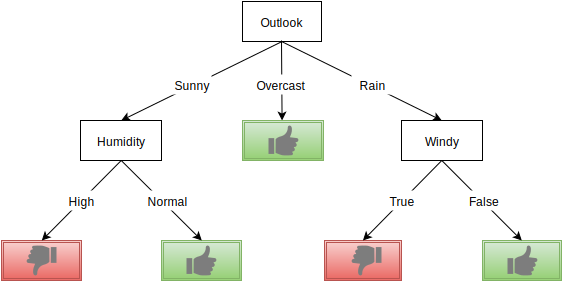

In [14]:
# figures created with https://www.draw.io/
from IPython.display import SVG
display(SVG(filename='figures/id3-simple.svg'))

It is clear from inspection that this tree is complete (i.e. all possible instances will be classified) and that it does not depend on all of the features (e.g. temperature is missing).

The second, more complicated, function that was developed requires a much larger tree to represent:

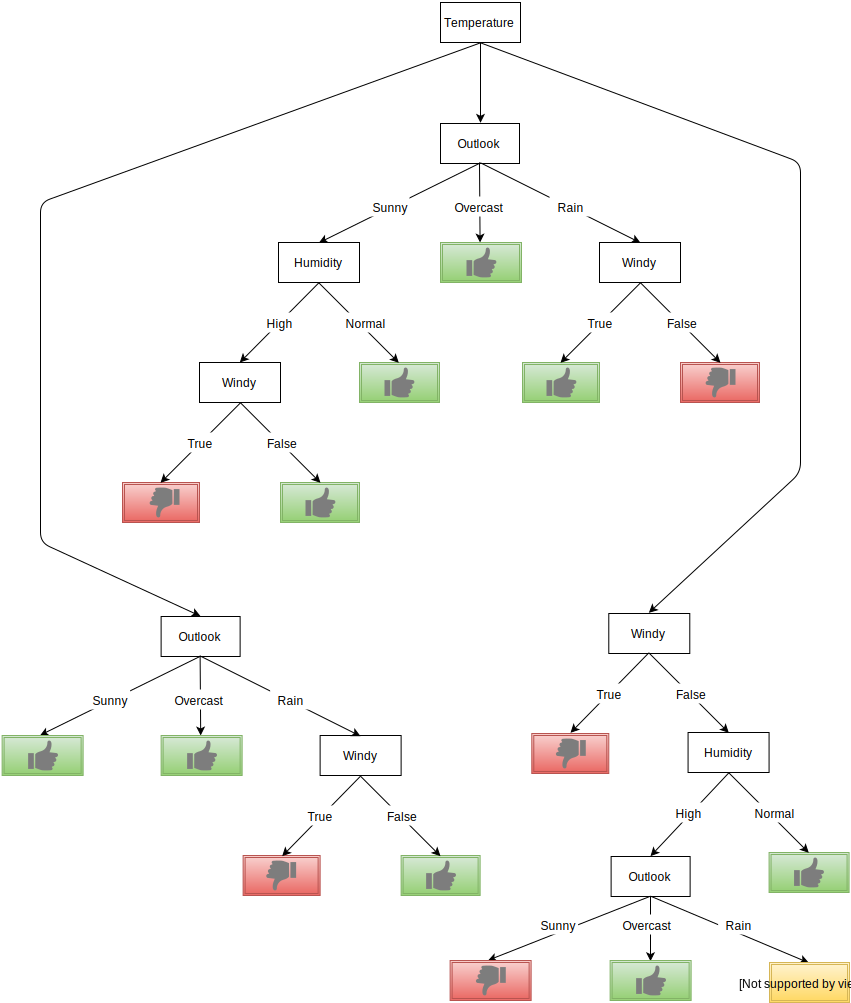

In [17]:
# figures created with https://www.draw.io/
from IPython.display import SVG
display(SVG(filename='figures/id3-complex.svg'))

This more complicated tree does depend on all of the features but, despite using all the available information, produced an incomplete classification function (i.e. not all possible instances are classified).

Based on the above experience and, more generally, the intuitive appeal of Occam's razor it seems that we should seek to produce the minimal complete decision tree when we are building a classification function.  Unfortunately, the problem of finding the minimal complete decision tree is intractable (i.e. NP-Complete) so we will need to rely on heuristics to build decision trees.